In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

cifar = fetch_openml('CIFAR_10', version=1, as_frame=False)

X = cifar['data']
y = cifar['target'].astype(int)

X_images = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

Kształt danych: (60000, 32, 32, 3)
Przykładowa etykieta: 8
Typ danych obrazów: int64
Kanały kolorów:  3


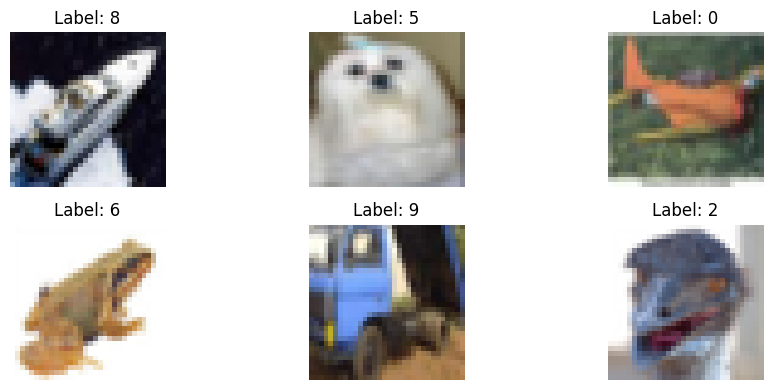

In [2]:
print("Kształt danych:", X_images.shape)
print("Przykładowa etykieta:", y[0])
print("Typ danych obrazów:", X_images[0].dtype)
print("Kanały kolorów: ", X_images.shape[-1])

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_images[i])
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Dataset zawiera 60000 obrazków.<br>
Każdy z obrazków jest w wymiarze 32x32 piksele, posiadając 3 kanały kolorów (RGB). <br>
W zbiorze obrazki etykietowane są numerycznie, posiadają 10 podstawowych klas, cyfry oznaczają następujące kategorie obrazów:

### Kategorie CIFAR-10

0 – airplane  
1 – automobile  
2 – bird  
3 – cat  
4 – deer  
5 – dog  
6 – frog  
7 – horse  
8 – ship  
9 – truck


In [3]:
image_shapes = {x.shape for x in X_images}
print("Unikalne rozmiary obrazów:", image_shapes)

Unikalne rozmiary obrazów: {(32, 32, 3)}


In [50]:
import pandas as pd

pd.Series(y).value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Podział danych względem klas jest idealny.

Każdy z obrazów jest w rozmiarach 32x32, więc nie potrzebuje przeskalowania. Jedynie jeśli będzie to potrzebne dla efektywniejszej ewaluacji modelu.

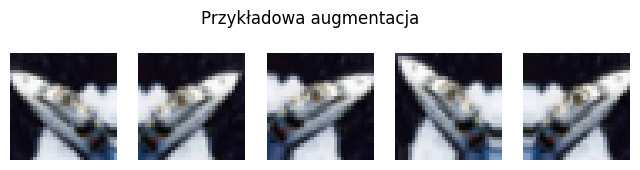

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_images)

sample = X_images[0].reshape((1, 32, 32, 3))
aug_iter = datagen.flow(sample, batch_size=1)

plt.figure(figsize=(8, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    augmented = next(aug_iter)[0].astype("uint8")
    plt.imshow(augmented)
    plt.axis("off")
plt.suptitle("Przykładowa augmentacja")
plt.show()

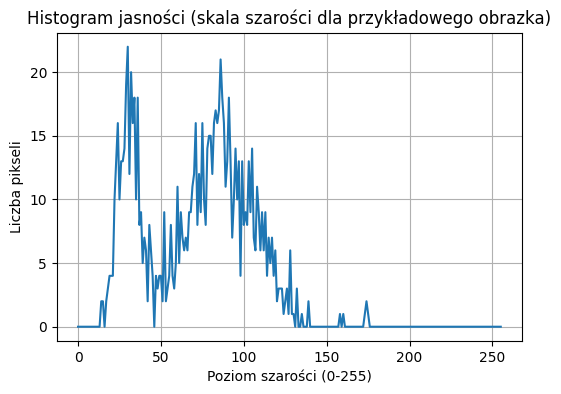

In [5]:
import cv2
from matplotlib import pyplot as plt

img = X_images[2137].astype('uint8')

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])

plt.figure(figsize=(6, 4))
plt.plot(hist)
plt.title("Histogram jasności (skala szarości dla przykładowego obrazka)")
plt.xlabel("Poziom szarości (0-255)")
plt.ylabel("Liczba pikseli")
plt.grid()
plt.show()

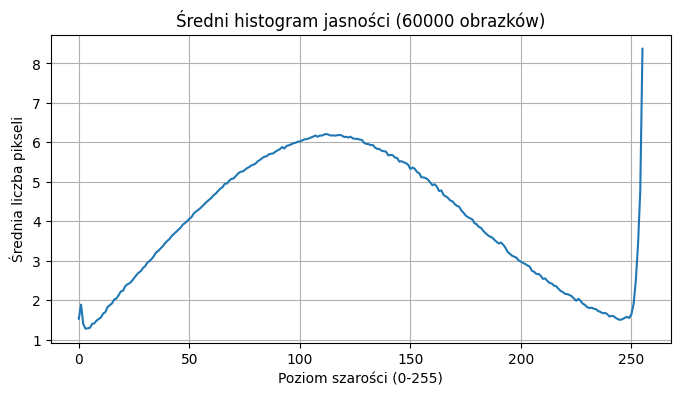

In [6]:
hist_total = np.zeros((256, 1))
n = X.shape[0]

for i in range(n):
    gray = cv2.cvtColor(X_images[i].astype('uint8'), cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_total += hist

hist_total /= n

plt.figure(figsize=(8, 4))
plt.plot(hist_total)
plt.title("Średni histogram jasności (" + str(n) + " obrazków)")
plt.xlabel("Poziom szarości (0-255)")
plt.ylabel("Średnia liczba pikseli")
plt.grid()
plt.show()

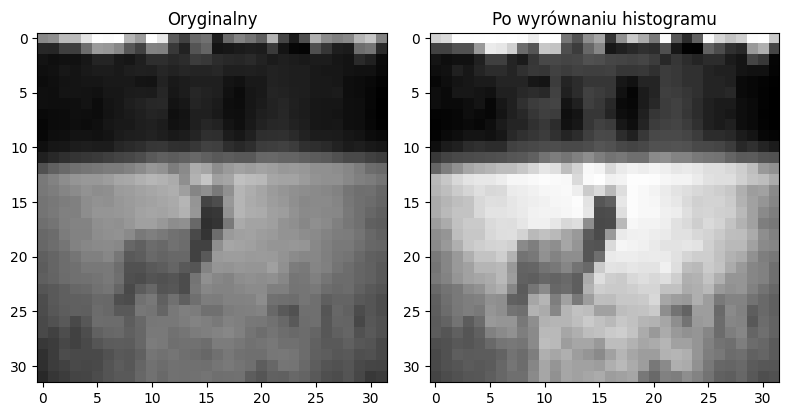

In [7]:
equalized_img = cv2.equalizeHist(gray_img)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Oryginalny")

plt.subplot(1, 2, 2)
plt.imshow(equalized_img, cmap='gray')
plt.title("Po wyrównaniu histogramu")

plt.tight_layout()
plt.show()

HOG + LBP + PCA i uczenie

In [34]:
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def get_hog_features(img):
    gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    return hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)


def get_lbp_features(img):
    gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    return hist / np.sum(hist)


def extract_features(X):
    hog_feats = np.array([get_hog_features(img) for img in X])
    lbp_feats = np.array([get_lbp_features(img) for img in X])

    X_features = np.concatenate([hog_feats, lbp_feats], axis=1)

    pca = PCA(n_components=40)
    return pca.fit_transform(X_features)


X_features = extract_features(X_images)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=2137)

In [9]:
def f1_score(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))

    f1_sum = 0.0
    for lbl in labels:
        tp = sum((yt == lbl and yp == lbl) for yt, yp in zip(y_true, y_pred))
        fp = sum((yt != lbl and yp == lbl) for yt, yp in zip(y_true, y_pred))
        fn = sum((yt == lbl and yp != lbl) for yt, yp in zip(y_true, y_pred))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        f1_sum += f1

    return f1_sum / len(labels)

### XGBoost

In [10]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
xgboost_fscore = f1_score(y_test, list(y_pred))

print(f"fscore: {xgboost_fscore:.3f}")

fscore: 0.532


In [11]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
catboost_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {catboost_fscore:.3f}")

Learning rate set to 0.096398
0:	learn: 2.2351843	total: 96ms	remaining: 1m 35s
1:	learn: 2.1735183	total: 133ms	remaining: 1m 6s
2:	learn: 2.1234729	total: 163ms	remaining: 54s
3:	learn: 2.0839222	total: 196ms	remaining: 48.7s
4:	learn: 2.0471126	total: 240ms	remaining: 47.8s
5:	learn: 2.0133559	total: 274ms	remaining: 45.4s
6:	learn: 1.9834768	total: 305ms	remaining: 43.2s
7:	learn: 1.9582647	total: 344ms	remaining: 42.6s
8:	learn: 1.9335679	total: 381ms	remaining: 41.9s
9:	learn: 1.9114464	total: 411ms	remaining: 40.7s
10:	learn: 1.8922513	total: 442ms	remaining: 39.7s
11:	learn: 1.8739250	total: 476ms	remaining: 39.1s
12:	learn: 1.8559148	total: 512ms	remaining: 38.9s
13:	learn: 1.8397436	total: 542ms	remaining: 38.2s
14:	learn: 1.8242045	total: 576ms	remaining: 37.8s
15:	learn: 1.8089188	total: 606ms	remaining: 37.3s
16:	learn: 1.7962862	total: 638ms	remaining: 36.9s
17:	learn: 1.7862959	total: 699ms	remaining: 38.1s
18:	learn: 1.7755889	total: 740ms	remaining: 38.2s
19:	learn: 1.

### AdaBoost

In [12]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
ada_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {ada_fscore:.3f}")

fscore: 0.300


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rf_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {rf_fscore:.3f}")

fscore: 0.485


### KNeighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
kn_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {kn_fscore:.3f}")

fscore: 0.483


### NuSVC

In [15]:
from sklearn.svm import NuSVC

model = NuSVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
nu_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {nu_fscore:.3f}")

fscore: 0.546


### Podsumowanie

In [16]:
import pandas as pd

models = [
    "xgboost",
    "catboost",
    "adaboost",
    "random forest",
    "k neighbors",
    "nusvc"
]

scores = [
    xgboost_fscore,
    catboost_fscore,
    ada_fscore,
    rf_fscore,
    kn_fscore,
    nu_fscore
]

pd.DataFrame({
    "model": models,
    "f1-score": scores
})

,model,f1-score
0,xgboost,0.532110
1,catboost,0.560924
2,adaboost,0.300499
3,random forest,0.484578
4,k neighbors,0.482770
5,nusvc,0.545868


Najlepszy okazał się catboost osiągając wynik f1-score na poziomie: **0.561**

### Cross-validation

In [24]:
def split_set_into_cross_validation(
        X: np.ndarray,
        Y: np.ndarray,
        n_splits: int = 5,
        random_state: int = 2137
) -> list[tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    n_samples = len(indices)
    fold_sizes = [n_samples // n_splits + (1 if i < n_samples % n_splits else 0) for i in range(n_splits)]

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))

        X_train = X[train_idx]
        Y_train = Y[train_idx]
        X_test = X[test_idx]
        Y_test = Y[test_idx]

        folds.append((X_train, Y_train, X_test, Y_test))
        current = stop

    return folds

Learning rate set to 0.116668
0:	learn: 2.2167292	test: 2.2180996	best: 2.2180996 (0)	total: 46.5ms	remaining: 46.5s
1:	learn: 2.1452646	test: 2.1493677	best: 2.1493677 (1)	total: 72.9ms	remaining: 36.4s
2:	learn: 2.0899153	test: 2.0968673	best: 2.0968673 (2)	total: 101ms	remaining: 33.6s
3:	learn: 2.0433701	test: 2.0527373	best: 2.0527373 (3)	total: 128ms	remaining: 31.9s
4:	learn: 2.0034068	test: 2.0142488	best: 2.0142488 (4)	total: 155ms	remaining: 30.8s
5:	learn: 1.9694855	test: 1.9812005	best: 1.9812005 (5)	total: 185ms	remaining: 30.7s
6:	learn: 1.9390029	test: 1.9524841	best: 1.9524841 (6)	total: 218ms	remaining: 31s
7:	learn: 1.9143925	test: 1.9288933	best: 1.9288933 (7)	total: 251ms	remaining: 31.1s
8:	learn: 1.8888856	test: 1.9045731	best: 1.9045731 (8)	total: 280ms	remaining: 30.8s
9:	learn: 1.8680528	test: 1.8847097	best: 1.8847097 (9)	total: 313ms	remaining: 31s
10:	learn: 1.8490498	test: 1.8667155	best: 1.8667155 (10)	total: 346ms	remaining: 31.1s
11:	learn: 1.8307310	tes

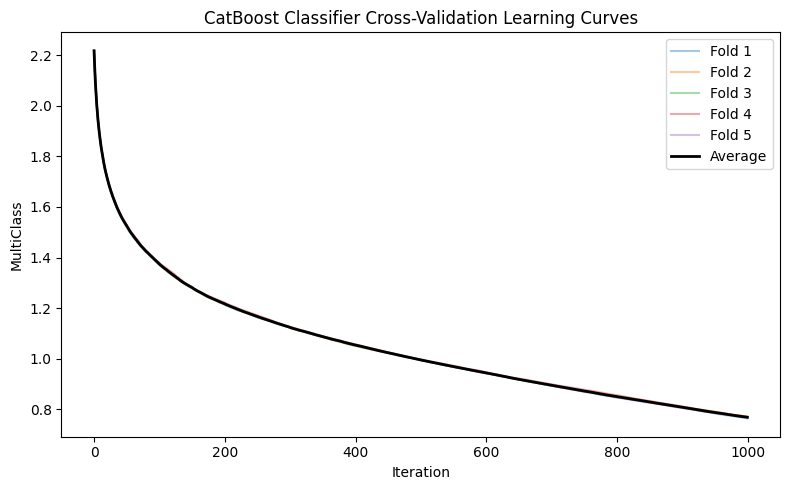

In [27]:
from catboost import CatBoostClassifier

all_curves = []
folds = split_set_into_cross_validation(X_features, y)

for i, (X_train, Y_train, X_eval, Y_eval) in enumerate(folds):
    model = CatBoostClassifier(
        eval_metric='MultiClass',
        random_seed=2137,
    )

    model.fit(
        X_train,
        Y_train,
        eval_set=(X_eval, Y_eval),
    )

    evals = model.get_evals_result()
    curve = evals['learn']['MultiClass']
    all_curves.append(curve)

min_len = min(len(c) for c in all_curves)
trimmed = [c[:min_len] for c in all_curves]
avg_curve = np.mean(np.vstack(trimmed), axis=0).tolist()

plt.figure(figsize=(8, 5))
for idx, curve in enumerate(trimmed, 1):
    plt.plot(curve, alpha=0.4, label=f'Fold {idx}')
plt.plot(avg_curve, color='black', linewidth=2, label='Average')
plt.xlabel('Iteration')
plt.ylabel('MultiClass')
plt.title('CatBoost Classifier Cross-Validation Learning Curves')
plt.legend()
plt.tight_layout()
plt.show()


### Macierz koleracji

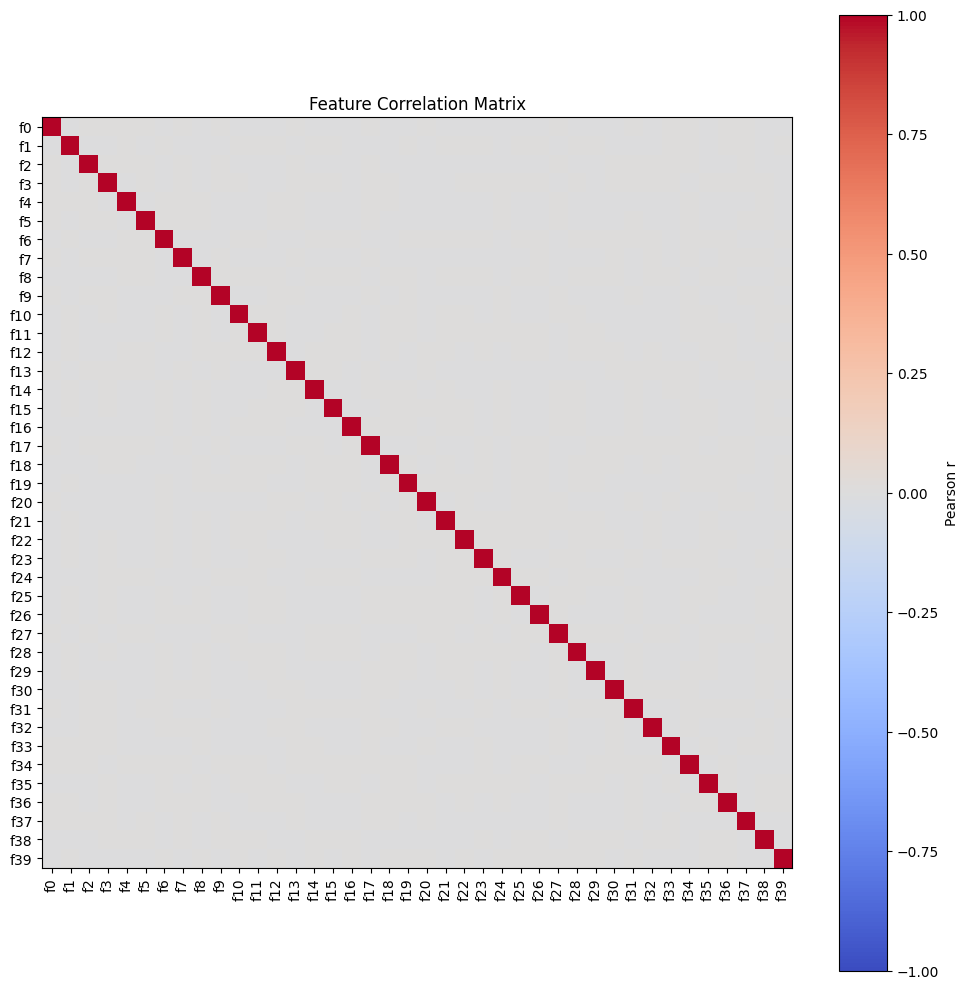

In [18]:
corr = np.corrcoef(X_features, rowvar=False)

plt.figure(figsize=(10, 10))
plt.imshow(corr, interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.title("Feature Correlation Matrix")
plt.xticks(range(X_features.shape[1]), [f"f{i}" for i in range(X_features.shape[1])], rotation=90)
plt.yticks(range(X_features.shape[1]), [f"f{i}" for i in range(X_features.shape[1])])
plt.tight_layout()
plt.show()

Jak widać na załączonym wykresie, żadna z cech nie jest ze sobą powiązana, co jest dobrą informacją w kontekście optymalizacji modeli opartych na drzewach decyzyjnych.

## Optymalizacja parametrów

### Grid search

In [19]:
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(verbose=True, random_seed=2137)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 300, 500],
    # 'depth':               [4, 6, 8],
    # 'bagging_temperature': [0.0, 1.0, 2.0],
    # 'random_strength':     [0, 1, 2]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

fscore = f1_score(y_test, y_pred.flatten().tolist())
print(f"fscore: {fscore:.3f}")

0:	learn: 2.2945984	total: 215ms	remaining: 21.3s
0:	learn: 2.2944021	total: 150ms	remaining: 14.9s
0:	learn: 2.2944890	total: 179ms	remaining: 17.7s
0:	learn: 2.2629284	total: 271ms	remaining: 26.8s
0:	learn: 2.2635979	total: 225ms	remaining: 22.3s
1:	learn: 2.2865139	total: 384ms	remaining: 18.8s
0:	learn: 2.2946256	total: 247ms	remaining: 24.4s
0:	learn: 2.2945584	total: 267ms	remaining: 26.5s
0:	learn: 2.2625040	total: 267ms	remaining: 26.4s
1:	learn: 2.2862080	total: 387ms	remaining: 18.9s
1:	learn: 2.2862640	total: 403ms	remaining: 19.7s
1:	learn: 2.2271295	total: 417ms	remaining: 20.4s
1:	learn: 2.2285385	total: 423ms	remaining: 20.7s
2:	learn: 2.2786221	total: 606ms	remaining: 19.6s
1:	learn: 2.2863585	total: 472ms	remaining: 23.1s
1:	learn: 2.2868613	total: 497ms	remaining: 24.3s
1:	learn: 2.2261696	total: 540ms	remaining: 26.5s
2:	learn: 2.2784846	total: 588ms	remaining: 19s
2:	learn: 2.2782245	total: 592ms	remaining: 19.1s
2:	learn: 2.1954089	total: 614ms	remaining: 19.9s
3:

### Optuna

In [20]:
import optuna


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        # "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        # "depth": trial.suggest_int("depth", 4, 10),
        # "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 0,
        "task_type": "CPU",
        "random_seed": 2137,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

    preds = model.predict(X_test).flatten().tolist()
    return f1_score(y_test, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best f1-score:", study.best_value)

best_model = CatBoostClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test).flatten().tolist()
print("Final test f1-score:", f1_score(y_test, y_pred))

[I 2025-06-14 13:31:17,378] A new study created in memory with name: no-name-19ab16b4-3724-481c-89c3-e1b301fe7a44
[I 2025-06-14 13:31:27,952] Trial 0 finished with value: 0.5093180792478125 and parameters: {'iterations': 267, 'learning_rate': 0.0692643063804953, 'l2_leaf_reg': 7.161967826076181}. Best is trial 0 with value: 0.5093180792478125.
[I 2025-06-14 13:31:41,026] Trial 1 finished with value: 0.5178394986939477 and parameters: {'iterations': 473, 'learning_rate': 0.04303473930881639, 'l2_leaf_reg': 2.613288813115129}. Best is trial 1 with value: 0.5178394986939477.
[I 2025-06-14 13:31:45,562] Trial 2 finished with value: 0.4288871408959351 and parameters: {'iterations': 149, 'learning_rate': 0.027168009268625885, 'l2_leaf_reg': 9.942996654170882}. Best is trial 1 with value: 0.5178394986939477.
[I 2025-06-14 13:31:53,618] Trial 3 finished with value: 0.32700740467272665 and parameters: {'iterations': 282, 'learning_rate': 0.0012737353398546696, 'l2_leaf_reg': 4.46452086543384}. 

Best parameters: {'iterations': 443, 'learning_rate': 0.2677498317582497, 'l2_leaf_reg': 3.4322331034794304}
Best f1-score: 0.553261545937904
0:	learn: 2.1347771	total: 27.1ms	remaining: 12s
1:	learn: 2.0284570	total: 54.9ms	remaining: 12.1s
2:	learn: 1.9439397	total: 84.8ms	remaining: 12.4s
3:	learn: 1.8891847	total: 112ms	remaining: 12.3s
4:	learn: 1.8409725	total: 143ms	remaining: 12.5s
5:	learn: 1.8011050	total: 171ms	remaining: 12.5s
6:	learn: 1.7692150	total: 201ms	remaining: 12.5s
7:	learn: 1.7401356	total: 233ms	remaining: 12.7s
8:	learn: 1.7158700	total: 260ms	remaining: 12.5s
9:	learn: 1.6931089	total: 287ms	remaining: 12.4s
10:	learn: 1.6736551	total: 314ms	remaining: 12.3s
11:	learn: 1.6561283	total: 343ms	remaining: 12.3s
12:	learn: 1.6353178	total: 370ms	remaining: 12.2s
13:	learn: 1.6196191	total: 401ms	remaining: 12.3s
14:	learn: 1.6068800	total: 431ms	remaining: 12.3s
15:	learn: 1.5923689	total: 458ms	remaining: 12.2s
16:	learn: 1.5790189	total: 486ms	remaining: 12.2s


### Genetic Algorithm

In [21]:
import pygad
import numpy as np
from catboost import CatBoostClassifier

param_bounds = {
    "learning_rate": (0.01, 0.3),
    "l2_leaf_reg": (1.0, 10.0),
    "iterations": (100, 500),
    # "depth": (4, 10),
    # "random_strength": (1e-3, 10),
    # "bagging_temperature": (0.0, 1.0)
}

param_names = list(param_bounds.keys())


def decode_chromosome(solution):
    params = {}
    for i, key in enumerate(param_names):
        low, high = param_bounds[key]
        val = solution[i]
        val = max(min(val, high), low)

        if key in ["depth", "iterations", "border_count"]:
            params[key] = int(round(val))
        else:
            params[key] = float(val)

    params["verbose"] = 0
    params["random_seed"] = 2137
    params["task_type"] = "CPU"
    return params


def fitness_func(ga_instance, solution, solution_idx):
    params = decode_chromosome(solution)
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=20,
        verbose=0
    )
    preds = model.predict(X_test).flatten().tolist()
    return f1_score(y_test, preds)


def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {best_solution_fitness}")
    print("Best solution parameters:")
    decoded_params = decode_chromosome(best_solution)
    for k, v in decoded_params.items():
        print(f"  {k}: {v}")
    print("-" * 30)


num_generations = 20
num_parents_mating = 5
sol_per_pop = 10
num_genes = len(param_names)

gene_space = [
    {"low": param_bounds[name][0], "high": param_bounds[name][1]}
    for name in param_names
]

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    keep_elitism=2,
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    random_seed=2137,
    parallel_processing=["thread", 5],
    on_generation=on_generation,
)

ga_instance.run()

best_solution, best_solution_fitness, _ = ga_instance.best_solution()
best_params = decode_chromosome(best_solution)
print("Best Parameters found by PyGAD:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best F1-score: {best_solution_fitness}")


/Users/lisa/pythonProject/lib/python3.12/site-packages/pygad/pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=20) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


Generation 1: Best Fitness = 0.5561325067521521
Best solution parameters:
  learning_rate: 0.236907310580562
  l2_leaf_reg: 8.982069301476592
  iterations: 452
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 2: Best Fitness = 0.5561325067521521
Best solution parameters:
  learning_rate: 0.236907310580562
  l2_leaf_reg: 8.982069301476592
  iterations: 452
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 3: Best Fitness = 0.5561325067521521
Best solution parameters:
  learning_rate: 0.236907310580562
  l2_leaf_reg: 8.982069301476592
  iterations: 452
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 4: Best Fitness = 0.5561325067521521
Best solution parameters:
  learning_rate: 0.236907310580562
  l2_leaf_reg: 8.982069301476592
  iterations: 452
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 5: Best Fitness = 0.55614

##### Zestawienie wyników
1. Grid-search
    - f1-score: *0.550*
    - parametry:
        -  iterations: 500,
        -  l2_leaf_reg: 1,
        -  learning_rate: 0.1

2. Optuna
    - f1-score: *0.551*
    - parametry:
        -  iterations: 443,
        -  l2_leaf_reg: 3.4322331034794304,
        -  learning_rate: 0.2677498317582497

3. Genetic Algorithm
    - f1-score: *0.556*
    - parametry:
        -  iterations: 449,
        -  l2_leaf_reg: 8.983456072883023,
        -  learning_rate: 0.236907310580562


Najlepsze parametry do modelu znalazł algorytm genetyczny. Warto jednak zaznaczyć, że również najdłużej on szukał wyników po ponad aż 1h.

In [36]:
final_model = CatBoostClassifier(iterations=449, l2_leaf_reg=8.983456072883023, learning_rate=0.236907310580562,
                                 random_seed=2137)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test).flatten().tolist()

final_fscore = f1_score(y_pred, y_test)

print(f'Final f1-score: {final_fscore:.3f}')

0:	learn: 2.1491417	total: 99.1ms	remaining: 44.4s
1:	learn: 2.0445750	total: 200ms	remaining: 44.7s
2:	learn: 1.9774833	total: 281ms	remaining: 41.7s
3:	learn: 1.9184898	total: 349ms	remaining: 38.8s
4:	learn: 1.8771826	total: 391ms	remaining: 34.7s
5:	learn: 1.8385680	total: 417ms	remaining: 30.8s
6:	learn: 1.8052296	total: 445ms	remaining: 28.1s
7:	learn: 1.7803604	total: 472ms	remaining: 26s
8:	learn: 1.7569467	total: 506ms	remaining: 24.7s
9:	learn: 1.7326658	total: 533ms	remaining: 23.4s
10:	learn: 1.7123846	total: 561ms	remaining: 22.3s
11:	learn: 1.6997372	total: 592ms	remaining: 21.6s
12:	learn: 1.6836798	total: 624ms	remaining: 20.9s
13:	learn: 1.6661047	total: 650ms	remaining: 20.2s
14:	learn: 1.6533965	total: 678ms	remaining: 19.6s
15:	learn: 1.6380997	total: 709ms	remaining: 19.2s
16:	learn: 1.6255419	total: 740ms	remaining: 18.8s
17:	learn: 1.6138081	total: 779ms	remaining: 18.7s
18:	learn: 1.6020858	total: 810ms	remaining: 18.3s
19:	learn: 1.5926190	total: 838ms	remainin

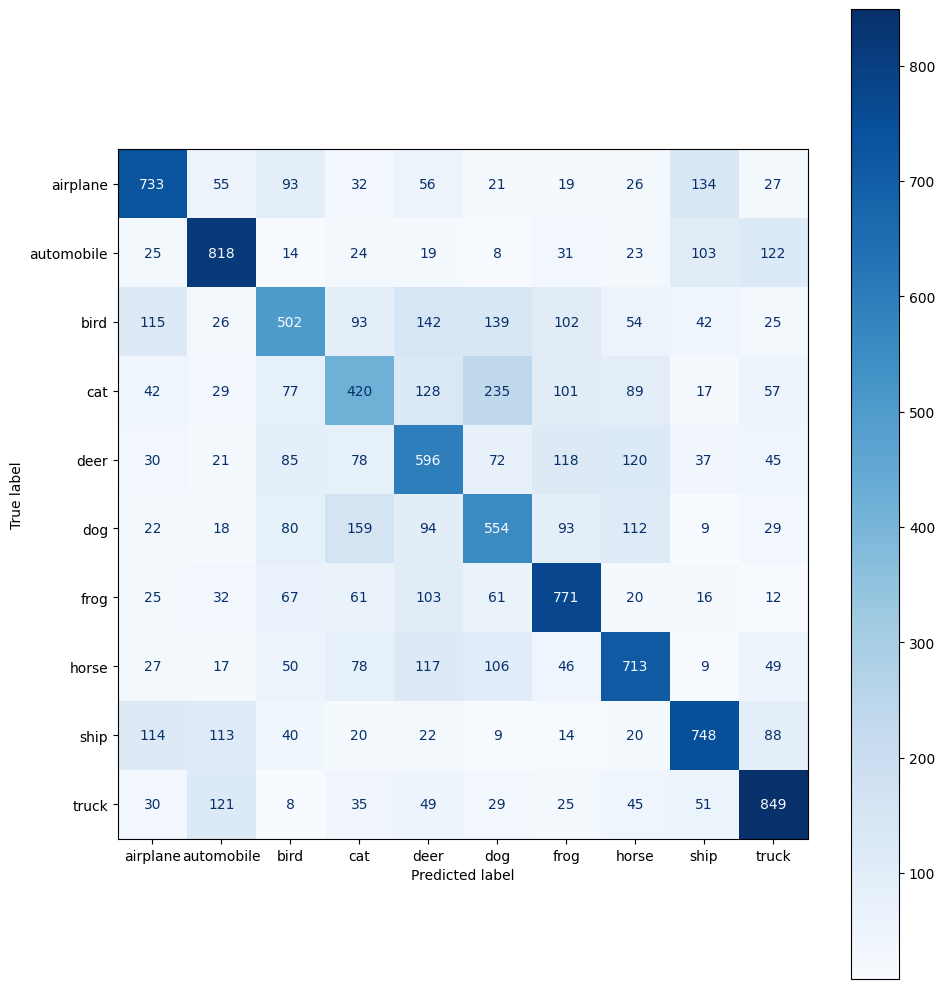

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="Blues", ax=ax)
plt.tight_layout()
plt.show()

### Podsumowanie

Po wydobyciu cech i optymalizacji hiperparametrów najlepszego modelu, nie osiąga on rewelacyjnych wyników. Drzewa decyzyjne nie sprawdzają się najlepiej w klasyfikowaniu zdjęć.
